## 任务目标：利用异烟酸生产过程中的各参数，预测最终异烟酸的收率
- 数据集包括生产工程中10个步骤的参数，样本id、A1-A28、B1-B14包括原料、辅料、时间、温度、压强等以及收率
- 冠军ATCG解决方案

![title](1.png)

In [1]:
import pandas as pd
import numpy as np
import warnings
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as mse

warnings.simplefilter('ignore')

In [2]:
df_trn = pd.read_csv(
        'data/jinnan_round1_train_20181227.csv', encoding='GB2312')
df_tst_a = pd.read_csv(
        'data/jinnan_round1_testA_20181227.csv', encoding='GB2312')
df_tst_b = pd.read_csv(
        'data/jinnan_round1_testB_20190121.csv', encoding='GB2312')

In [3]:
df_trn.head()

,样本id,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,B6,B7,B8,B9,B10,B11,B12,B13,B14,收率
0,sample_1528,300,NaN,405.0,700,13:30:00,38.0,NaN,NaN,15:30:00,...,65,11:30:00,45.0,11:30-13:00,14:00-15:30,NaN,800.0,0.15,400,0.879
1,sample_1698,300,NaN,405.0,700,14:00:00,29.0,NaN,NaN,16:00:00,...,80,6:00:00,45.0,6:00-7:30,7:30-9:00,9:00-10:00,1200.0,0.15,400,0.902
2,sample_639,300,NaN,405.0,700,14:00:00,29.0,NaN,NaN,16:00:00,...,80,1:00:00,45.0,1:00-2:30,2:30-4:00,4:00-5:00,1200.0,0.15,400,0.936
3,sample_483,300,NaN,405.0,700,1:30:00,38.0,NaN,NaN,3:00:00,...,65,18:00:00,45.0,19:00-20:30,21:30-23:00,NaN,800.0,0.15,400,0.902
4,sample_617,300,NaN,405.0,700,22:00:00,29.0,NaN,NaN,0:00:00,...,80,9:00:00,45.0,9:00-10:30,10:30-12:00,12:00-13:00,1200.0,0.15,420,0.983


In [4]:
df_trn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1396 entries, 0 to 1395
Data columns (total 44 columns):
样本id    1396 non-null object
A1      1396 non-null int64
A2      42 non-null float64
A3      1354 non-null float64
A4      1396 non-null int64
A5      1396 non-null object
A6      1396 non-null float64
A7      149 non-null object
A8      149 non-null float64
A9      1396 non-null object
A10     1396 non-null int64
A11     1396 non-null object
A12     1396 non-null int64
A13     1396 non-null float64
A14     1396 non-null object
A15     1396 non-null float64
A16     1396 non-null object
A17     1396 non-null float64
A18     1396 non-null float64
A19     1396 non-null int64
A20     1396 non-null object
A21     1393 non-null float64
A22     1396 non-null float64
A23     1393 non-null float64
A24     1395 non-null object
A25     1396 non-null object
A26     1394 non-null object
A27     1396 non-null int64
A28     1396 non-null object
B1      1386 non-null float64
B2      1394 non-null

#### 数据检查与问题修正

In [5]:
def train_abnormal_revise(data):
    df_trn = data.copy() 
    df_trn.loc[(df_trn['A1'] == 200) & (df_trn['A3'] == 405), 'A1'] = 300
    df_trn['A5'] = df_trn['A5'].replace('1900/1/21 0:00', '21:00:00')
    df_trn['A5'] = df_trn['A5'].replace('1900/1/29 0:00', '14:00:00')
    df_trn['A9'] = df_trn['A9'].replace('1900/1/9 7:00', '23:00:00')
    df_trn['A9'] = df_trn['A9'].replace('700', '7:00:00')
    df_trn['A11'] = df_trn['A11'].replace(':30:00', '00:30:00')
    df_trn['A11'] = df_trn['A11'].replace('1900/1/1 2:30', '21:30:00')
    df_trn['A16'] = df_trn['A16'].replace('1900/1/12 0:00', '12:00:00')
    df_trn['A20'] = df_trn['A20'].replace('6:00-6:30分', '6:00-6:30')
    df_trn['A20'] = df_trn['A20'].replace('18:30-15:00', '18:30-19:00')
    df_trn['A22'] = df_trn['A22'].replace(3.5, np.nan)
    df_trn['A25'] = df_trn['A25'].replace('1900/3/10 0:00', 70).astype(int)
    df_trn['A26'] = df_trn['A26'].replace('1900/3/13 0:00', '13:00:00')
    df_trn['B1'] = df_trn['B1'].replace(3.5, np.nan)
    df_trn['B4'] = df_trn['B4'].replace('15:00-1600', '15:00-16:00')
    df_trn['B4'] = df_trn['B4'].replace('18:00-17:00', '16:00-17:00')
    df_trn['B4'] = df_trn['B4'].replace('19:-20:05', '19:05-20:05')
    df_trn['B9'] = df_trn['B9'].replace('23:00-7:30', '23:00-00:30')
    df_trn['B14'] = df_trn['B14'].replace(40, 400)
    return df_trn


def test_a_abnormal_revise(data):
    df_tst = data.copy()
    df_tst['A5'] = df_tst['A5'].replace('1900/1/22 0:00', '22:00:00')
    df_tst['A7'] = df_tst['A7'].replace('0:50:00', '21:50:00')
    df_tst['B14'] = df_tst['B14'].replace(785, 385)
    return df_tst


def train_abnormal_adjust(data):
    df_trn = data.copy()
    df_trn.loc[df_trn['样本id'] == 'sample_1894', 'A5'] = '14:00:00'
    df_trn.loc[df_trn['样本id'] == 'sample_1234', 'A9'] = '0:00:00'
    df_trn.loc[df_trn['样本id'] == 'sample_1020', 'A9'] = '18:30:00'

    df_trn.loc[df_trn['样本id'] == 'sample_1380', 'A11'] = '15:30:00'
    df_trn.loc[df_trn['样本id'] == 'sample_844', 'A11'] = '10:00:00'
    df_trn.loc[df_trn['样本id'] == 'sample_1348', 'A11'] = '17:00:00'
    df_trn.loc[df_trn['样本id'] == 'sample_25', 'A11'] = '00:30:00'
    df_trn.loc[df_trn['样本id'] == 'sample_1105', 'A11'] = '4:00:00'
    df_trn.loc[df_trn['样本id'] == 'sample_313', 'A11'] = '15:30:00'

    df_trn.loc[df_trn['样本id'] == 'sample_291', 'A14'] = '19:30:00'

    df_trn.loc[df_trn['样本id'] == 'sample_1398', 'A16'] = '11:00:00'
    df_trn.loc[df_trn['样本id'] == 'sample_1177', 'A20'] = '19:00-20:00'

    df_trn.loc[df_trn['样本id'] == 'sample_71', 'A20'] = '16:20-16:50'
    df_trn.loc[df_trn['样本id'] == 'sample_14', 'A20'] = '18:00-18:30'
    df_trn.loc[df_trn['样本id'] == 'sample_69', 'A20'] = '6:10-6:50'
    df_trn.loc[df_trn['样本id'] == 'sample_1500', 'A20'] = '23:00-23:30'

    df_trn.loc[df_trn['样本id'] == 'sample_1524', 'A24'] = '15:00:00'
    df_trn.loc[df_trn['样本id'] == 'sample_1524', 'A26'] = '15:30:00'

    df_trn.loc[df_trn['样本id'] == 'sample_1046', 'A28'] = '18:00-18:30'

    df_trn.loc[df_trn['样本id'] == 'sample_1230', 'B5'] = '17:00:00'
    df_trn.loc[df_trn['样本id'] == 'sample_97', 'B7'] = '1:00:00'
    df_trn.loc[df_trn['样本id'] == 'sample_752', 'B9'] = '11:00-14:00'

    df_trn.loc[df_trn['样本id'] == 'sample_609', 'B11'] = '11:00-12:00'
    df_trn.loc[df_trn['样本id'] == 'sample_643', 'B11'] = '12:00-13:00'
    df_trn.loc[df_trn['样本id'] == 'sample_1164', 'B11'] = '5:00-6:00'
    return df_trn


def test_a_abnormal_adjust(data):
    df_tst = data.copy()
    df_tst.loc[df_tst['样本id'] == 'sample_919', 'A9'] = '19:50:00'
    return df_tst


def test_b_abnormal_adjust(data):
    df_tst = data.copy()
    df_tst.loc[df_tst['样本id'] == 'sample_566', 'A5'] = '18:00:00'
    df_tst.loc[df_tst['样本id'] == 'sample_40', 'A20'] = '5:00-5:30'
    df_tst.loc[df_tst['样本id'] == 'sample_531', 'B5'] = '1:00'
    return df_tst

In [6]:
df_trn = train_abnormal_revise(df_trn).pipe(train_abnormal_adjust)
df_tst_a = test_a_abnormal_revise(df_tst_a).pipe(test_a_abnormal_adjust)
df_tst_b = test_b_abnormal_adjust(df_tst_b)

#### 标签与数据集整合

In [7]:
df_trn, df_tst = df_trn.copy(), df_tst_a.copy()
df_target = df_trn['收率']
del df_trn['收率']
df_trn_tst = df_trn.append(df_tst, ignore_index=False).reset_index(
    drop=True)

In [8]:
for _df in [df_trn, df_tst, df_trn_tst]:
    _df['A3'] = _df['A3'].fillna(405)

#### 时间段特征处理 

In [9]:
# 所有时间相关列
cols_timer = ['A5', 'A7', 'A9', 'A11', 'A14', 'A16', 'A24', 'A26', 'B5', 'B7']
# 同时对训练和测试集进行相同处理
for _df in [df_trn_tst, df_trn, df_tst]:
    # 添加列名标记
    _df.rename(columns={_col: _col + '_t' for _col in cols_timer},
               inplace=True)
    # 遍历所有持续时间相关列例如21:00-21:30
    for _col in ['A20', 'A28', 'B4', 'B9', 'B10', 'B11']:
        # 取到当前列的索引
        _idx_col = _df.columns.tolist().index(_col)
        # 添加新的一列，表示起始时间，split表示分别取开始和结束时间，用索引来指定
        _df.insert(_idx_col + 1, _col + '_at',
                   _df[_col].str.split('-').str[0])
        # 添加新的一列，表示终止时间
        _df.insert(_idx_col + 2, _col + '_bt',
                   _df[_col].str.split('-').str[1])
        # 删除持续时间
        del _df[_col]
        cols_timer = cols_timer + [_col + '_at', _col + '_bt']

In [10]:
df_trn_tst.head()

,样本id,A1,A2,A3,A4,A5_t,A6,A7_t,A8,A9_t,...,B8,B9_at,B9_bt,B10_at,B10_bt,B11_at,B11_bt,B12,B13,B14
0,sample_1528,300,NaN,405.0,700,13:30:00,38.0,NaN,NaN,15:30:00,...,45.0,11:30,13:00,14:00,15:30,NaN,NaN,800.0,0.15,400
1,sample_1698,300,NaN,405.0,700,14:00:00,29.0,NaN,NaN,16:00:00,...,45.0,6:00,7:30,7:30,9:00,9:00,10:00,1200.0,0.15,400
2,sample_639,300,NaN,405.0,700,14:00:00,29.0,NaN,NaN,16:00:00,...,45.0,1:00,2:30,2:30,4:00,4:00,5:00,1200.0,0.15,400
3,sample_483,300,NaN,405.0,700,1:30:00,38.0,NaN,NaN,3:00:00,...,45.0,19:00,20:30,21:30,23:00,NaN,NaN,800.0,0.15,400
4,sample_617,300,NaN,405.0,700,22:00:00,29.0,NaN,NaN,0:00:00,...,45.0,9:00,10:30,10:30,12:00,12:00,13:00,1200.0,0.15,420


In [11]:
cols_timer = list(filter(lambda x: x.endswith('t'), df_trn_tst.columns))

In [12]:
cols_timer

['A5_t',
 'A7_t',
 'A9_t',
 'A11_t',
 'A14_t',
 'A16_t',
 'A20_at',
 'A20_bt',
 'A24_t',
 'A26_t',
 'A28_at',
 'A28_bt',
 'B4_at',
 'B4_bt',
 'B5_t',
 'B7_t',
 'B9_at',
 'B9_bt',
 'B10_at',
 'B10_bt',
 'B11_at',
 'B11_bt']

将时间全部转换成分钟形式

In [13]:
def time_to_min(x):
    if x is np.nan:
        return np.nan
    else:
        x = x.replace(';', ':').replace('；', ':')
        x = x.replace('::', ':').replace('"', ':')
        h, m = x.split(':')[:2]
        h = 0 if not h else h
        m = 0 if not m else m
        return int(h)*60 + int(m)

In [14]:
for _df in [df_trn_tst, df_trn, df_tst]:
    for _col in cols_timer:
        _df[_col] = _df[_col].map(time_to_min)

In [15]:
df_trn_tst.head()

,样本id,A1,A2,A3,A4,A5_t,A6,A7_t,A8,A9_t,...,B8,B9_at,B9_bt,B10_at,B10_bt,B11_at,B11_bt,B12,B13,B14
0,sample_1528,300,NaN,405.0,700,810,38.0,NaN,NaN,930,...,45.0,690,780,840.0,930.0,NaN,NaN,800.0,0.15,400
1,sample_1698,300,NaN,405.0,700,840,29.0,NaN,NaN,960,...,45.0,360,450,450.0,540.0,540.0,600.0,1200.0,0.15,400
2,sample_639,300,NaN,405.0,700,840,29.0,NaN,NaN,960,...,45.0,60,150,150.0,240.0,240.0,300.0,1200.0,0.15,400
3,sample_483,300,NaN,405.0,700,90,38.0,NaN,NaN,180,...,45.0,1140,1230,1290.0,1380.0,NaN,NaN,800.0,0.15,400
4,sample_617,300,NaN,405.0,700,1320,29.0,NaN,NaN,0,...,45.0,540,630,630.0,720.0,720.0,780.0,1200.0,0.15,420


### 创建一个df来准备添加嗷嗷多特征

In [16]:
raw = df_trn_tst.copy()
df = pd.DataFrame(raw['样本id'])
df.head()

,样本id
0,sample_1528
1,sample_1698
2,sample_639
3,sample_483
4,sample_617


#### 温度相关特征

In [17]:
# 加热过程
df['P1_S1_A6_0C'] = raw['A6']  # 容器初始温度
df['P1_S2_A8_1C'] = raw['A8']  # 首次测温温度
df['P1_S3_A10_2C'] = raw['A10']  # 准备水解温度
df['P1_C1_C0_D'] = raw['A8'] - raw['A6']  # 测温温差
df['P1_C2_C0_D'] = raw['A10'] - raw['A6']  # 初次沸腾温差

# 水解过程
df['P2_S1_A12_3C'] = raw['A12']  # 水解开始温度
df['P2_S2_A15_4C'] = raw['A15']  # 水解过程测温温度
df['P2_S3_A17_5C'] = raw['A17']  # 水解结束温度
df['P2_C3_C0_D'] = raw['A12'] - raw['A6']  # 水解开始与初始温度温差
df['P2_C3_C2_D'] = raw['A12'] - raw['A10']  # 水解开始前恒温温差
df['P2_C4_C3_D'] = raw['A15'] - raw['A12']  # 水解过程中途温差
df['P2_C5_C4_D'] = raw['A17'] - raw['A15']  # 水解结束中途温差
df['P2_C5_C3_KD'] = raw['A17'] - raw['A12']  # 水解起止温差

# 脱色过程
df['P3_S2_A25_7C'] = raw['A25']  # 脱色保温开始温度
df['P3_S3_A27_8C'] = raw['A27']  # 脱色保温结束温度
df['P3_C7_C5_D'] = raw['A25'] - raw['A17']  # 降温温差
df['P3_C8_C7_KD'] = raw['A27'] - raw['A25']  # 保温温差

# 结晶过程
df['P4_S2_B6_11C'] = raw['B6']  # 结晶开始温度
df['P4_S3_B8_12C'] = raw['B8']  # 结晶结束温度
df['P4_C11_C8_D'] = raw['B6'] - raw['A27']  # 脱色结束到结晶温差
df['P4_C12_C11_KD'] = raw['B8'] - raw['B6']  # 结晶温差

#### 温度相关统计特征

In [18]:
_funcs = ['mean', 'std', 'sum']
# 遍历每一种统计指标
for _func in _funcs:
    # 对每一个样本计算各项指标
    df[f'P2_C2-C5_{_func}'] = raw[['A10', 'A12', 'A15', 'A17']].\
        agg(_func, axis=1)  # 沸腾过程温度
    df[f'P2_D3-D5_{_func}'] = \
        df[[f'P2_C{i}_C{i-1}_D' for i in range(3, 6)]].\
            abs().agg(_func, axis=1)  # 沸腾过程绝对温差
    df[f'P2_C1-C12_KD_ABS_{_func}'] = \
        df[[_f for _f in df.columns if _f.endswith('KD')]].\
            abs().agg(_func, axis=1)  # 关键过程绝对温差
    df[f'P2_C1-C12_D_{_func}'] = \
        df[[_f for _f in df.columns if _f.endswith('D')]].\
            abs().agg(_func, axis=1)  # 所有过程绝对温差
    df[f'P2_LARGE_KD_{_func}'] = \
        df[['P2_C3_C0_D', 'P3_C7_C5_D', 'P4_C12_C11_KD']].\
            abs().agg(_func, axis=1)  # 大温差绝对温差

In [19]:
df.head()

,样本id,P1_S1_A6_0C,P1_S2_A8_1C,P1_S3_A10_2C,P1_C1_C0_D,P1_C2_C0_D,P2_S1_A12_3C,P2_S2_A15_4C,P2_S3_A17_5C,P2_C3_C0_D,...,P2_C2-C5_std,P2_D3-D5_std,P2_C1-C12_KD_ABS_std,P2_C1-C12_D_std,P2_LARGE_KD_std,P2_C2-C5_sum,P2_D3-D5_sum,P2_C1-C12_KD_ABS_sum,P2_C1-C12_D_sum,P2_LARGE_KD_sum
0,sample_1528,38.0,NaN,100,NaN,62.0,102.0,103.0,104.0,64.0,...,1.707825,0.57735,9.643651,24.928565,23.245071,409.0,4.0,27.0,191.0,113.0
1,sample_1698,29.0,NaN,101,NaN,72.0,103.0,104.0,105.0,74.0,...,1.707825,0.57735,17.785762,28.887521,25.890796,413.0,4.0,44.0,226.0,134.0
2,sample_639,29.0,NaN,102,NaN,73.0,103.0,104.0,105.0,74.0,...,1.290994,0.00000,18.009257,29.231642,25.514702,414.0,3.0,43.0,226.0,135.0
3,sample_483,38.0,NaN,100,NaN,62.0,102.0,103.0,104.0,64.0,...,1.707825,0.57735,9.165151,24.617293,22.479620,409.0,4.0,30.0,207.0,118.0
4,sample_617,29.0,NaN,101,NaN,72.0,103.0,104.0,105.0,74.0,...,1.707825,0.57735,17.785762,28.887521,25.890796,413.0,4.0,44.0,226.0,134.0


得到温度相关特征

In [20]:
df_temperature = df.set_index('样本id')

In [21]:
df_temperature.head()

,P1_S1_A6_0C,P1_S2_A8_1C,P1_S3_A10_2C,P1_C1_C0_D,P1_C2_C0_D,P2_S1_A12_3C,P2_S2_A15_4C,P2_S3_A17_5C,P2_C3_C0_D,P2_C3_C2_D,...,P2_C2-C5_std,P2_D3-D5_std,P2_C1-C12_KD_ABS_std,P2_C1-C12_D_std,P2_LARGE_KD_std,P2_C2-C5_sum,P2_D3-D5_sum,P2_C1-C12_KD_ABS_sum,P2_C1-C12_D_sum,P2_LARGE_KD_sum
样本id,,,,,,,,,,,,,,,,,,,,,
sample_1528,38.0,NaN,100,NaN,62.0,102.0,103.0,104.0,64.0,2.0,...,1.707825,0.57735,9.643651,24.928565,23.245071,409.0,4.0,27.0,191.0,113.0
sample_1698,29.0,NaN,101,NaN,72.0,103.0,104.0,105.0,74.0,2.0,...,1.707825,0.57735,17.785762,28.887521,25.890796,413.0,4.0,44.0,226.0,134.0
sample_639,29.0,NaN,102,NaN,73.0,103.0,104.0,105.0,74.0,1.0,...,1.290994,0.00000,18.009257,29.231642,25.514702,414.0,3.0,43.0,226.0,135.0
sample_483,38.0,NaN,100,NaN,62.0,102.0,103.0,104.0,64.0,2.0,...,1.707825,0.57735,9.165151,24.617293,22.479620,409.0,4.0,30.0,207.0,118.0
sample_617,29.0,NaN,101,NaN,72.0,103.0,104.0,105.0,74.0,2.0,...,1.707825,0.57735,17.785762,28.887521,25.890796,413.0,4.0,44.0,226.0,134.0


#### 时间相关特征

In [22]:
# 时间计算方式转换
def duration_outer(series1, series2):
    duration = series1 - series2
    duration = np.where(duration < 0, duration + 24*60, duration)
    duration = np.where(duration > 12*60, 24*60 - duration, duration)
    duration = np.where(duration > 6*60, 12*60 - duration, duration)
    return duration

In [23]:
raw = df_trn_tst.copy()
df = pd.DataFrame(raw['样本id'])
# 加热过程
df['P1_S1_A5_0T'] = raw['A5_t']  # 初始时刻
df['P1_S2_A9_2T'] = raw['A9_t']  # 初始时刻
df['P1_T1_T0_D'] = duration_outer(raw['A7_t'], raw['A5_t'])
# 初次测温时间差
df['P1_T2_T1_D'] = duration_outer(raw['A9_t'], raw['A7_t'])
# 二次测温时间差
df['P1_T2_T0_K_D'] = duration_outer(raw['A9_t'], raw['A5_t'])
# 开始加热至沸腾时间差

# 水解过程
df['P2_S1_A11_3T'] = raw['A11_t']  # 水解开始时刻
df['P2_S1_A16_5T'] = raw['A16_t']  # 水解结束时刻

df['P2_T3_T0_K_D'] = duration_outer(raw['A11_t'], raw['A5_t'])
# 开始加热至投料时间差
df['P2_T3_T2_K_D'] = duration_outer(raw['A11_t'], raw['A9_t'])
# 恒温至投料投料时间差
# df['P2_T4_T3_D'] = raw['A14_t'] - raw['A11_t']  # 水解初次测温时间差
# df['P2_T5_T4_D'] = raw['A16_t'] - raw['A14_t']  # 水解结束时间差
df['P2_T5_T3_K_D'] = duration_outer(raw['A16_t'], raw['A11_t'])
# 水解时间差

# 脱色过程
df['P3_S1_A20_6T'] = raw['A20_at']  # 中和开始时刻
df['P3_S2_A25_7T'] = raw['A24_t']  # 保温时刻

df['P3_T6_T5_K_D'] = duration_outer(raw['A20_at'], raw['A16_t'])
# 水解结束至中和间歇时间
df['P3_T6_T6_K_D'] = duration_outer(raw['A20_bt'], raw['A20_at'])
# 酸碱度中和时间
df['P3_T7_T6_D'] = duration_outer(raw['A24_t'], raw['A20_bt'])
# 中和结束至脱色间歇时间
df['P3_T8_T7_K_D'] = duration_outer(raw['A26_t'], raw['A24_t'])
# 脱色保温时间
df['P3_T9_T8_D'] = duration_outer(raw['A28_at'], raw['A26_t'])
# 脱色至抽滤间歇时间
df['P3_T9_T9_K_D'] = duration_outer(raw['A28_bt'], raw['A28_at'])
# 抽滤时间
df['P3_T9_T5_1D'] = duration_outer(raw['A28_bt'], raw['A16_t'])
df['P3_T9_T6_2D'] = duration_outer(raw['A28_bt'], raw['A20_at'])
# 脱色总时间

# 结晶过程
df['P4_S1_B4_10T'] = raw['B4_at']  # 酸化开始时刻
df['P4_S2_B5_11T'] = raw['B5_t']  # 结晶开始时刻
df['P4_S3_B7_12T'] = raw['B7_t']  # 结晶结束时刻

df['P4_T10_T9_D'] = duration_outer(raw['B4_at'], raw['A28_bt'])
# 抽滤结束至酸化间歇时间
df['P4_T10_T10_K_D'] = duration_outer(raw['B4_bt'], raw['B4_at'])
# 酸化时间
df['P4_T11_T10_K_D'] = duration_outer(raw['B5_t'], raw['B4_bt'])
# 酸化至结晶间歇时间
df['P4_T12_T11_K_D'] = duration_outer(raw['B7_t'], raw['B5_t'])
# 自然结晶时间
df['P4_T12_T9_1D'] = duration_outer(raw['B7_t'], raw['A28_bt'])
df['P4_T12_T10_2D'] = duration_outer(raw['B7_t'], raw['B4_at'])
# 结晶总时间

# 甩滤过程
df['P5_S1_B9_13T'] = raw['B9_at']  # 甩滤开始时刻
df['P5_S3_B12_15T'] = np.where(
    raw['B11_bt'].isnull(),
    np.where(raw['B10_bt'].isnull(), raw['B9_bt'], raw['B10_bt']),
    raw['B11_bt'])  # 甩滤结束时刻
df['P5_T13_T12_D'] = duration_outer(raw['B9_at'], raw['B7_t'])
# 酸化结束至甩滤间歇时间
df['P5_T13_T13_K_D'] = duration_outer(raw['B9_bt'], raw['B9_at'])
# 基本甩滤时间
df['P5_T14_T13_D'] = duration_outer(raw['B10_at'], raw['B9_bt'])
# 基本甩滤至补充甩滤1间歇时间
df['P5_T14_T14_K_D'] = duration_outer(raw['B10_bt'], raw['B10_at'])
# 补充甩滤1时间
df['P5_T15_T14_D'] = duration_outer(raw['B11_at'], raw['B10_bt'])
# 补充甩滤1至补充甩滤2间歇时间
df['P5_T15_T13_K_D'] = duration_outer(raw['B11_bt'], raw['B11_at'])
# 补充甩滤2时间
df['P5_T15_T13_1D'] = \
    df[['P5_T13_T13_K_D', 'P5_T14_T14_K_D', 'P5_T13_T13_K_D']].sum(axis=1)
df['P5_T15_T12_2D'] = duration_outer(
    df['P5_S3_B12_15T'], df['P4_S3_B7_12T'])
df['P5_T15_T12_3D'] = duration_outer(
    df['P5_S3_B12_15T'], df['P5_S1_B9_13T'])
# 总甩滤时间

# 总流程时长
df['P5_T15_T1_4D'] = \
    df[['P5_T15_T12_2D', 'P4_T12_T9_1D', 'P3_T9_T5_1D',
        'P2_T3_T0_K_D', 'P2_T5_T3_K_D']].sum(axis=1)
_funcs = ['mean', 'std', 'sum']
for _func in _funcs:
    df[f'P5__D_{_func}'] = \
        df[[_f for _f in df.columns if _f.endswith('_D')]].\
            abs().agg(_func, axis=1)
    df[f'P5_K_D_{_func}'] = \
        df[[_f for _f in df.columns if _f.endswith('_K_D')]]. \
            abs().agg(_func, axis=1)
    df[f'P5__D_{_func}'] = \
        df[[_f for _f in df.columns if _f.endswith('D')]]. \
            abs().agg(_func, axis=1)
df_duration = df.set_index('样本id')

In [37]:
df_duration.head()

,P1_S1_A5_0T,P1_S2_A9_2T,P1_T1_T0_D,P1_T2_T1_D,P1_T2_T0_K_D,P2_S1_A11_3T,P2_S1_A16_5T,P2_T3_T0_K_D,P2_T3_T2_K_D,P2_T5_T3_K_D,...,P5_T15_T13_1D,P5_T15_T12_2D,P5_T15_T12_3D,P5_T15_T1_4D,P5__D_mean,P5_K_D_mean,P5__D_std,P5_K_D_std,P5__D_sum,P5_K_D_sum
样本id,,,,,,,,,,,,,,,,,,,,,
sample_1528,810,930,NaN,NaN,120,990,1110,180,60,120,...,270.0,240.0,240.0,840.0,145.384615,90.000000,169.852425,63.639610,3780.0,1170.0
sample_1698,840,960,NaN,NaN,120,1020,1140,180,60,120,...,270.0,240.0,240.0,960.0,136.071429,90.000000,188.588113,76.258669,3810.0,1260.0
sample_639,840,960,NaN,NaN,120,1020,1140,180,60,120,...,270.0,240.0,240.0,900.0,123.214286,75.000000,173.654693,49.575118,3450.0,1050.0
sample_483,90,180,NaN,NaN,90,240,360,150,60,120,...,270.0,300.0,240.0,990.0,158.076923,73.846154,195.448596,46.822086,4110.0,960.0
sample_617,1320,0,NaN,NaN,120,60,180,180,60,120,...,270.0,240.0,240.0,900.0,123.214286,77.142857,173.846539,48.107024,3450.0,1080.0


#### 水耗相关特征

In [24]:
na_value=405

df_trn_tst = df_trn_tst.copy()
df = pd.DataFrame(raw['样本id'])
# 耗水
df['P2_W_1M'] = raw['A4']
df['P2_W_2M'] = raw['A19']
# 耗盐酸
df['P3_H_1M'] = raw['A21'].fillna(50)
df['P4_H_2M'] = raw['B1'].fillna(320)
# 氢氧化钠
df['P2_N_1M'] = raw['A3'].fillna(na_value)
# 4-氰基吡啶
df['P2_C_1M'] = raw['A1']

df['P5_W_3M'] = raw['B12'].fillna(1200)
df['P5_W_1M'] = df['P2_W_1M'] + df['P2_W_2M']
df['P5_W_3M'] = df['P2_W_1M'] + df['P2_W_2M'] + df['P5_W_3M']
df['P5_H_1M'] = df['P3_H_1M'] + df['P4_H_2M']
df['P5_M_0M'] = raw['A1'] + df['P2_N_1M'] + df['P5_W_1M'] + df['P4_H_2M']
df['P5_M_1M'] = df['P5_M_0M'] + df['P5_W_3M']
df['P5_M_2M'] = df['P5_M_1M'] + df['P3_H_1M']
# 理论产出
df['P5_O_1M'] = raw['B14']
df['P5_O_5M'] = raw['B14'].replace(418, 420).replace(405, 400).\
    replace(395, 390).replace(392, 390).replace(387, 380).\
    replace(385, 380).replace(370, 360).replace(350, 360).\
    replace(350, 360).replace(340, 360).replace(290, 280).\
    replace(260, 280).replace(256, 280)
_fs = [_f for _f in df.columns if _f.endswith('M')]
for _f in _fs[:-2]:
    df[f'{_f}_P5_O_1M_R'] = df['P5_O_1M'] / df[_f]
    df[f'{_f}_P5_O_5M_R'] = df['P5_O_5M'] / df[_f]
for i in range(len(_fs[:6])):
    _f, _sub_fs = _fs[i], _fs[(i+1):6]
    for _f_div in _sub_fs:
        df[f'{_f}_{_f_div}_R'] = df[_f] / df[_f_div]
df_materials = df.set_index('样本id')

In [25]:
raw = df_trn_tst.copy()
df = pd.DataFrame(raw['样本id'])
df['P5_NOT_NUM_N'] = raw.iloc[:, 1:-1].notnull().sum(axis=1)
df['P5_PH_1N'] = raw['A22']
df['P5_PH_2N'] = raw['A23']
df['P5_PH_2N'] = raw['B2']
df['P5_A7_1N'] = raw['A7_t'].isnull().astype(int)
df['P5_O_2M'] = (raw['B14'] <= 360).astype(int)
df['P5_1_3M'] = raw['B13']
df_interact = df.set_index('样本id')

In [38]:
df_interact.head()

,P5_NOT_NUM_N,P5_PH_1N,P5_PH_2N,P5_A7_1N,P5_O_2M,P5_1_3M
样本id,,,,,,
sample_1528,42,9.0,3.5,1,0,0.15
sample_1698,44,9.0,3.5,1,0,0.15
sample_639,44,9.0,3.5,1,0,0.15
sample_483,42,10.0,3.5,1,0,0.15
sample_617,44,9.0,3.5,1,0,0.15


### 合并所有特征

In [26]:
df_feature = pd.concat([df_materials, df_duration, df_temperature, df_interact], axis=1).reset_index()

In [27]:
df_trn = df_feature.iloc[:len(df_trn)].reset_index(drop=True)
df_trn['收率'] = df_target
df_tst = df_feature.iloc[len(df_trn):].reset_index(drop=True)
df_tst['收率'] = np.nan

In [28]:
df_trn.head()

,样本id,P2_W_1M,P2_W_2M,P3_H_1M,P4_H_2M,P2_N_1M,P2_C_1M,P5_W_3M,P5_W_1M,P5_H_1M,...,P2_C1-C12_KD_ABS_sum,P2_C1-C12_D_sum,P2_LARGE_KD_sum,P5_NOT_NUM_N,P5_PH_1N,P5_PH_2N,P5_A7_1N,P5_O_2M,P5_1_3M,收率
0,sample_1528,700,300,50.0,350.0,405.0,300,1800.0,1000,400.0,...,27.0,191.0,113.0,42,9.0,3.5,1,0,0.15,0.879
1,sample_1698,700,200,50.0,320.0,405.0,300,2100.0,900,370.0,...,44.0,226.0,134.0,44,9.0,3.5,1,0,0.15,0.902
2,sample_639,700,200,50.0,320.0,405.0,300,2100.0,900,370.0,...,43.0,226.0,135.0,44,9.0,3.5,1,0,0.15,0.936
3,sample_483,700,200,50.0,290.0,405.0,300,1700.0,900,340.0,...,30.0,207.0,118.0,42,10.0,3.5,1,0,0.15,0.902
4,sample_617,700,200,50.0,320.0,405.0,300,2100.0,900,370.0,...,44.0,226.0,134.0,44,9.0,3.5,1,0,0.15,0.983


In [29]:
for _df in [df_trn, df_tst]:
    _df.insert(1, 'id', _df['样本id'].str.split('_').str[1].astype(float))

In [30]:
df_trn.head()

,样本id,id,P2_W_1M,P2_W_2M,P3_H_1M,P4_H_2M,P2_N_1M,P2_C_1M,P5_W_3M,P5_W_1M,...,P2_C1-C12_KD_ABS_sum,P2_C1-C12_D_sum,P2_LARGE_KD_sum,P5_NOT_NUM_N,P5_PH_1N,P5_PH_2N,P5_A7_1N,P5_O_2M,P5_1_3M,收率
0,sample_1528,1528.0,700,300,50.0,350.0,405.0,300,1800.0,1000,...,27.0,191.0,113.0,42,9.0,3.5,1,0,0.15,0.879
1,sample_1698,1698.0,700,200,50.0,320.0,405.0,300,2100.0,900,...,44.0,226.0,134.0,44,9.0,3.5,1,0,0.15,0.902
2,sample_639,639.0,700,200,50.0,320.0,405.0,300,2100.0,900,...,43.0,226.0,135.0,44,9.0,3.5,1,0,0.15,0.936
3,sample_483,483.0,700,200,50.0,290.0,405.0,300,1700.0,900,...,30.0,207.0,118.0,42,10.0,3.5,1,0,0.15,0.902
4,sample_617,617.0,700,200,50.0,320.0,405.0,300,2100.0,900,...,44.0,226.0,134.0,44,9.0,3.5,1,0,0.15,0.983


筛选常规数据

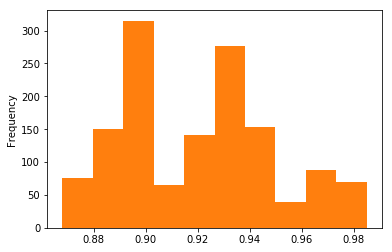

In [43]:
import matplotlib.pyplot as plt
df_trn['收率'].plot(kind='hist')
plt.show()

In [44]:
df_trn = df_trn.query('收率 > 0.8671').reset_index(drop=True)
df_trn = df_trn.query('收率 < 0.9861').reset_index(drop=True)

### 训练模型

In [46]:
def xgb_cv(train, test, params, fit_params, feature_names, nfold, seed):
    # 创建结果df
    train_pred = pd.DataFrame({
        'id': train['样本id'],
        'true': train['收率'],
        'pred': np.zeros(len(train))})
    # 测试提交结果
    test_pred = pd.DataFrame({'id': test['样本id'], 'pred': np.zeros(len(test))})
    # 交叉验证
    kfolder = KFold(n_splits=nfold, shuffle=True, random_state=seed)
    # 构造测试DMatrix
    xgb_tst = xgb.DMatrix(data=test[feature_names])
    print('\n')
    # 遍历cv中每一折数据，通过索引来指定
    for fold_id, (trn_idx, val_idx) in enumerate(kfolder.split(train['收率'])):
        # 构造当前训练的DMatrix
        xgb_trn = xgb.DMatrix(
            train.iloc[trn_idx][feature_names],
            train.iloc[trn_idx]['收率'])
        # 构造当前验证的DMatrix
        xgb_val = xgb.DMatrix(
            train.iloc[val_idx][feature_names],
            train.iloc[val_idx]['收率'])
        # 训练回归模型
        xgb_reg = xgb.train(params=params, dtrain=xgb_trn, **fit_params,
                  evals=[(xgb_trn, 'train'), (xgb_val, 'valid')])
        # 得到验证结果
        val_pred = xgb_reg.predict(
            xgb.DMatrix(train.iloc[val_idx][feature_names]),
            ntree_limit=xgb_reg.best_ntree_limit)
        train_pred.loc[val_idx, 'pred'] = val_pred
        # print(f'Fold_{fold_id}', mse(train.iloc[val_idx]['收率'], val_pred))
        test_pred['pred'] += xgb_reg.predict(
            xgb_tst, ntree_limit=xgb_reg.best_ntree_limit) / nfold
    print('\nCV LOSS:', mse(train_pred['true'], train_pred['pred']), '\n')
    return test_pred


设置训练参数

In [49]:
fit_params = {'num_boost_round': 10800,
              'verbose_eval': 300,
              'early_stopping_rounds': 360}
params_xgb = {'eta': 0.01, 'max_depth': 7, 'subsample': 0.8,
              'booster': 'gbtree', 'colsample_bytree': 0.8,
              'objective': 'reg:linear', 'silent': True, 'nthread': 4}

In [50]:
# 开始训练
pred_xgb_a = xgb_cv(df_trn, df_tst, params_xgb, fit_params,df_trn.columns.tolist()[1:-1], 5, 0)



[0]	train-rmse:0.420516	valid-rmse:0.417949
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 360 rounds.
[300]	train-rmse:0.023793	valid-rmse:0.023722
[600]	train-rmse:0.006579	valid-rmse:0.011484
[900]	train-rmse:0.004818	valid-rmse:0.011741
Stopping. Best iteration:
[591]	train-rmse:0.006675	valid-rmse:0.01148

[0]	train-rmse:0.419813	valid-rmse:0.420787
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 360 rounds.
[300]	train-rmse:0.023759	valid-rmse:0.02565
[600]	train-rmse:0.006628	valid-rmse:0.012122
[900]	train-rmse:0.004786	valid-rmse:0.012115
Stopping. Best iteration:
[739]	train-rmse:0.00563	valid-rmse:0.01206

[0]	train-rmse:0.419961	valid-rmse:0.420189
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 360 rounds.
[300]	trai

In [35]:
# 得到预测结果
df_tst_a['收率'] = pred_xgb_a['pred'].values

In [36]:
df_tst_a.head()

,样本id,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,B6,B7,B8,B9,B10,B11,B12,B13,B14,收率
0,sample_1656,300,NaN,405.0,700,6:00:00,29,NaN,NaN,8:00:00,...,79,17:00:00,45,17:00-18:30,18:30-20:00,20:00-21:00,1200,0.15,400,0.905592
1,sample_1548,300,NaN,405.0,700,12:30:00,39,12:50:00,80.0,14:20:00,...,65,10:00:00,45,12:00-13:00,14:00-15:30,NaN,800,0.15,385,0.879489
2,sample_769,300,NaN,405.0,700,6:00:00,80,NaN,NaN,8:00:00,...,80,17:00:00,45,17:00-20:00,NaN,NaN,1200,0.15,440,0.934109
3,sample_1881,300,NaN,405.0,700,22:00:00,29,NaN,NaN,0:00:00,...,80,9:00:00,45,9:00-10:30,10:30-12:00,12:00-13:00,1200,0.15,400,0.903917
4,sample_1807,300,NaN,405.0,700,22:00:00,30,NaN,NaN,0:00:00,...,79,9:00:00,45,9:00-10:30,10:30-12:00,12:00-13:00,1200,0.15,400,0.928389
